In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from scipy import stats
import missingno as msno

## 1. Load Dataset

In [2]:
dataset_filepath = 'data/Polish_Banks/polish_banks_dataset.csv'
attribute_names_file_path = 'data/Polish_Banks/attr_names.pickle'
perform_outlier_removal = True
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv(dataset_filepath)
with open(attribute_names_file_path, 'rb') as f:
    attr_names = pickle.load(f)

# replace with more descriptive names
df['class'].replace({'b\'0\'': 'Not bankrupt', 'b\'1\'': 'Bankrupt'}, inplace=True)

## 2. Dataset Exploration

,count,mean,std,min,25%,50%,75%,max
Attr1,10503.0,0.052844,0.647797,-1.769200e+01,0.000686,0.043034,0.123805,52.652
Attr2,10503.0,0.619911,6.427041,0.000000e+00,0.253955,0.464140,0.689330,480.730
Attr3,10503.0,0.095490,6.420056,-4.797300e+02,0.017461,0.198560,0.419545,17.708
Attr4,10485.0,9.980499,523.691951,2.080200e-03,1.040100,1.605600,2.959500,53433.000
Attr5,10478.0,-1347.662372,118580.569222,-1.190300e+07,-52.070750,1.579300,56.084000,685440.000
...,...,...,...,...,...,...,...,...
Attr60,9911.0,571.336309,37159.672255,0.000000e+00,5.533150,9.952100,20.936000,3660200.000
Attr61,10486.0,13.935361,83.704103,-6.590300e+00,4.486075,6.677300,10.587500,4470.400
Attr62,10460.0,135.536989,25991.162023,-2.336500e+06,40.737000,70.664000,118.220000,1073500.000
Attr63,10485.0,9.095149,31.419096,-1.562200e-04,3.062800,5.139200,8.882600,1974.500


class         2
Attr59     5555
Attr37     5558
Attr6      5864
Attr21     7962
          ...  
Attr40    10032
Attr16    10039
Attr12    10080
Attr55    10156
Attr5     10186
Length: 65, dtype: int64

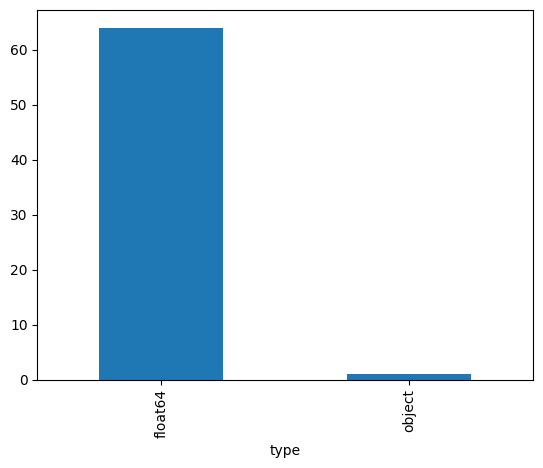

In [4]:
display(df.describe().T)

datatypes = pd.DataFrame(df.dtypes, columns=["type"]).reset_index()
datatypes.groupby("type").count().plot(kind='bar', legend=False)
object_values = datatypes[datatypes["type"] == "object"]["index"].values
df[object_values]
non_object_values = datatypes[datatypes["type"] != "object"]["index"].values

df.nunique().sort_values()


In [5]:
(df.max(numeric_only=True)-df.min(numeric_only=True)).sort_values()
display(df.Attr5.describe().T)
display(attr_names['Attr5'])
display(df.Attr29.describe().T)
display(attr_names['Attr29'])

count    1.047800e+04
mean    -1.347662e+03
std      1.185806e+05
min     -1.190300e+07
25%     -5.207075e+01
50%      1.579300e+00
75%      5.608400e+01
max      6.854400e+05
Name: Attr5, dtype: float64

'[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365'

count    10503.000000
mean         3.921179
std          0.840528
min         -0.358530
25%          3.393200
50%          3.932100
75%          4.449950
max          9.619900
Name: Attr29, dtype: float64

'logarithm of total assets'

## 3. Missing Values

<Axes: >

<Figure size 640x480 with 0 Axes>

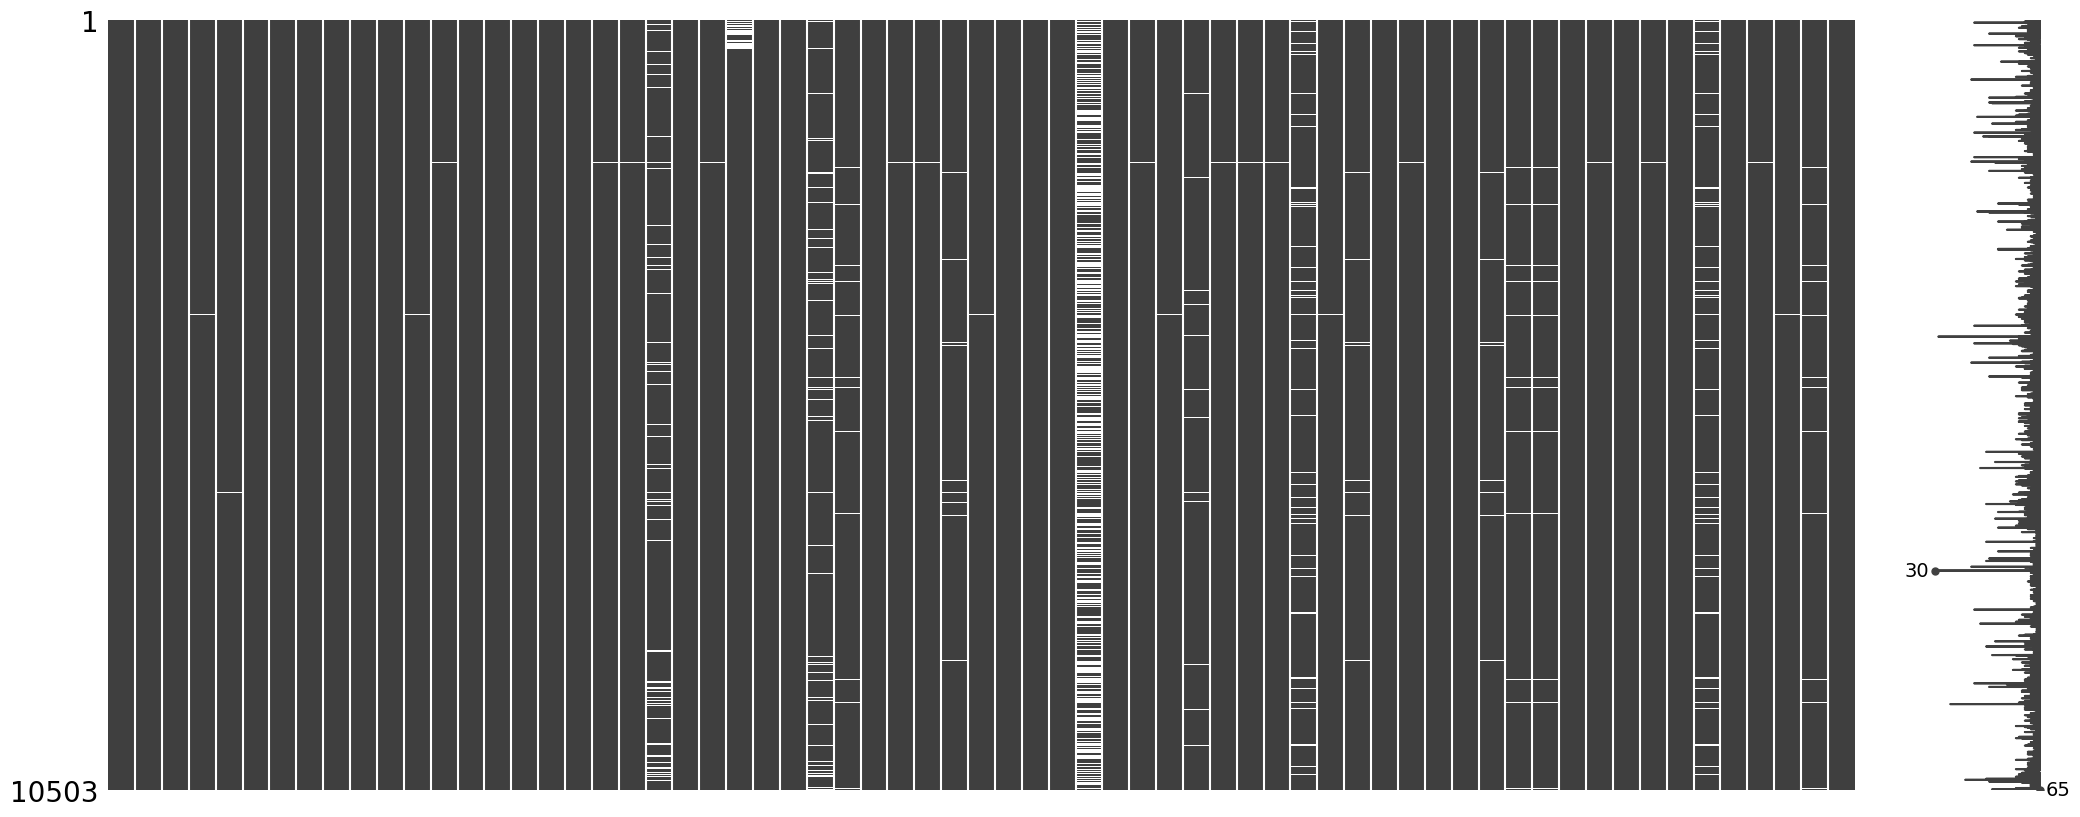

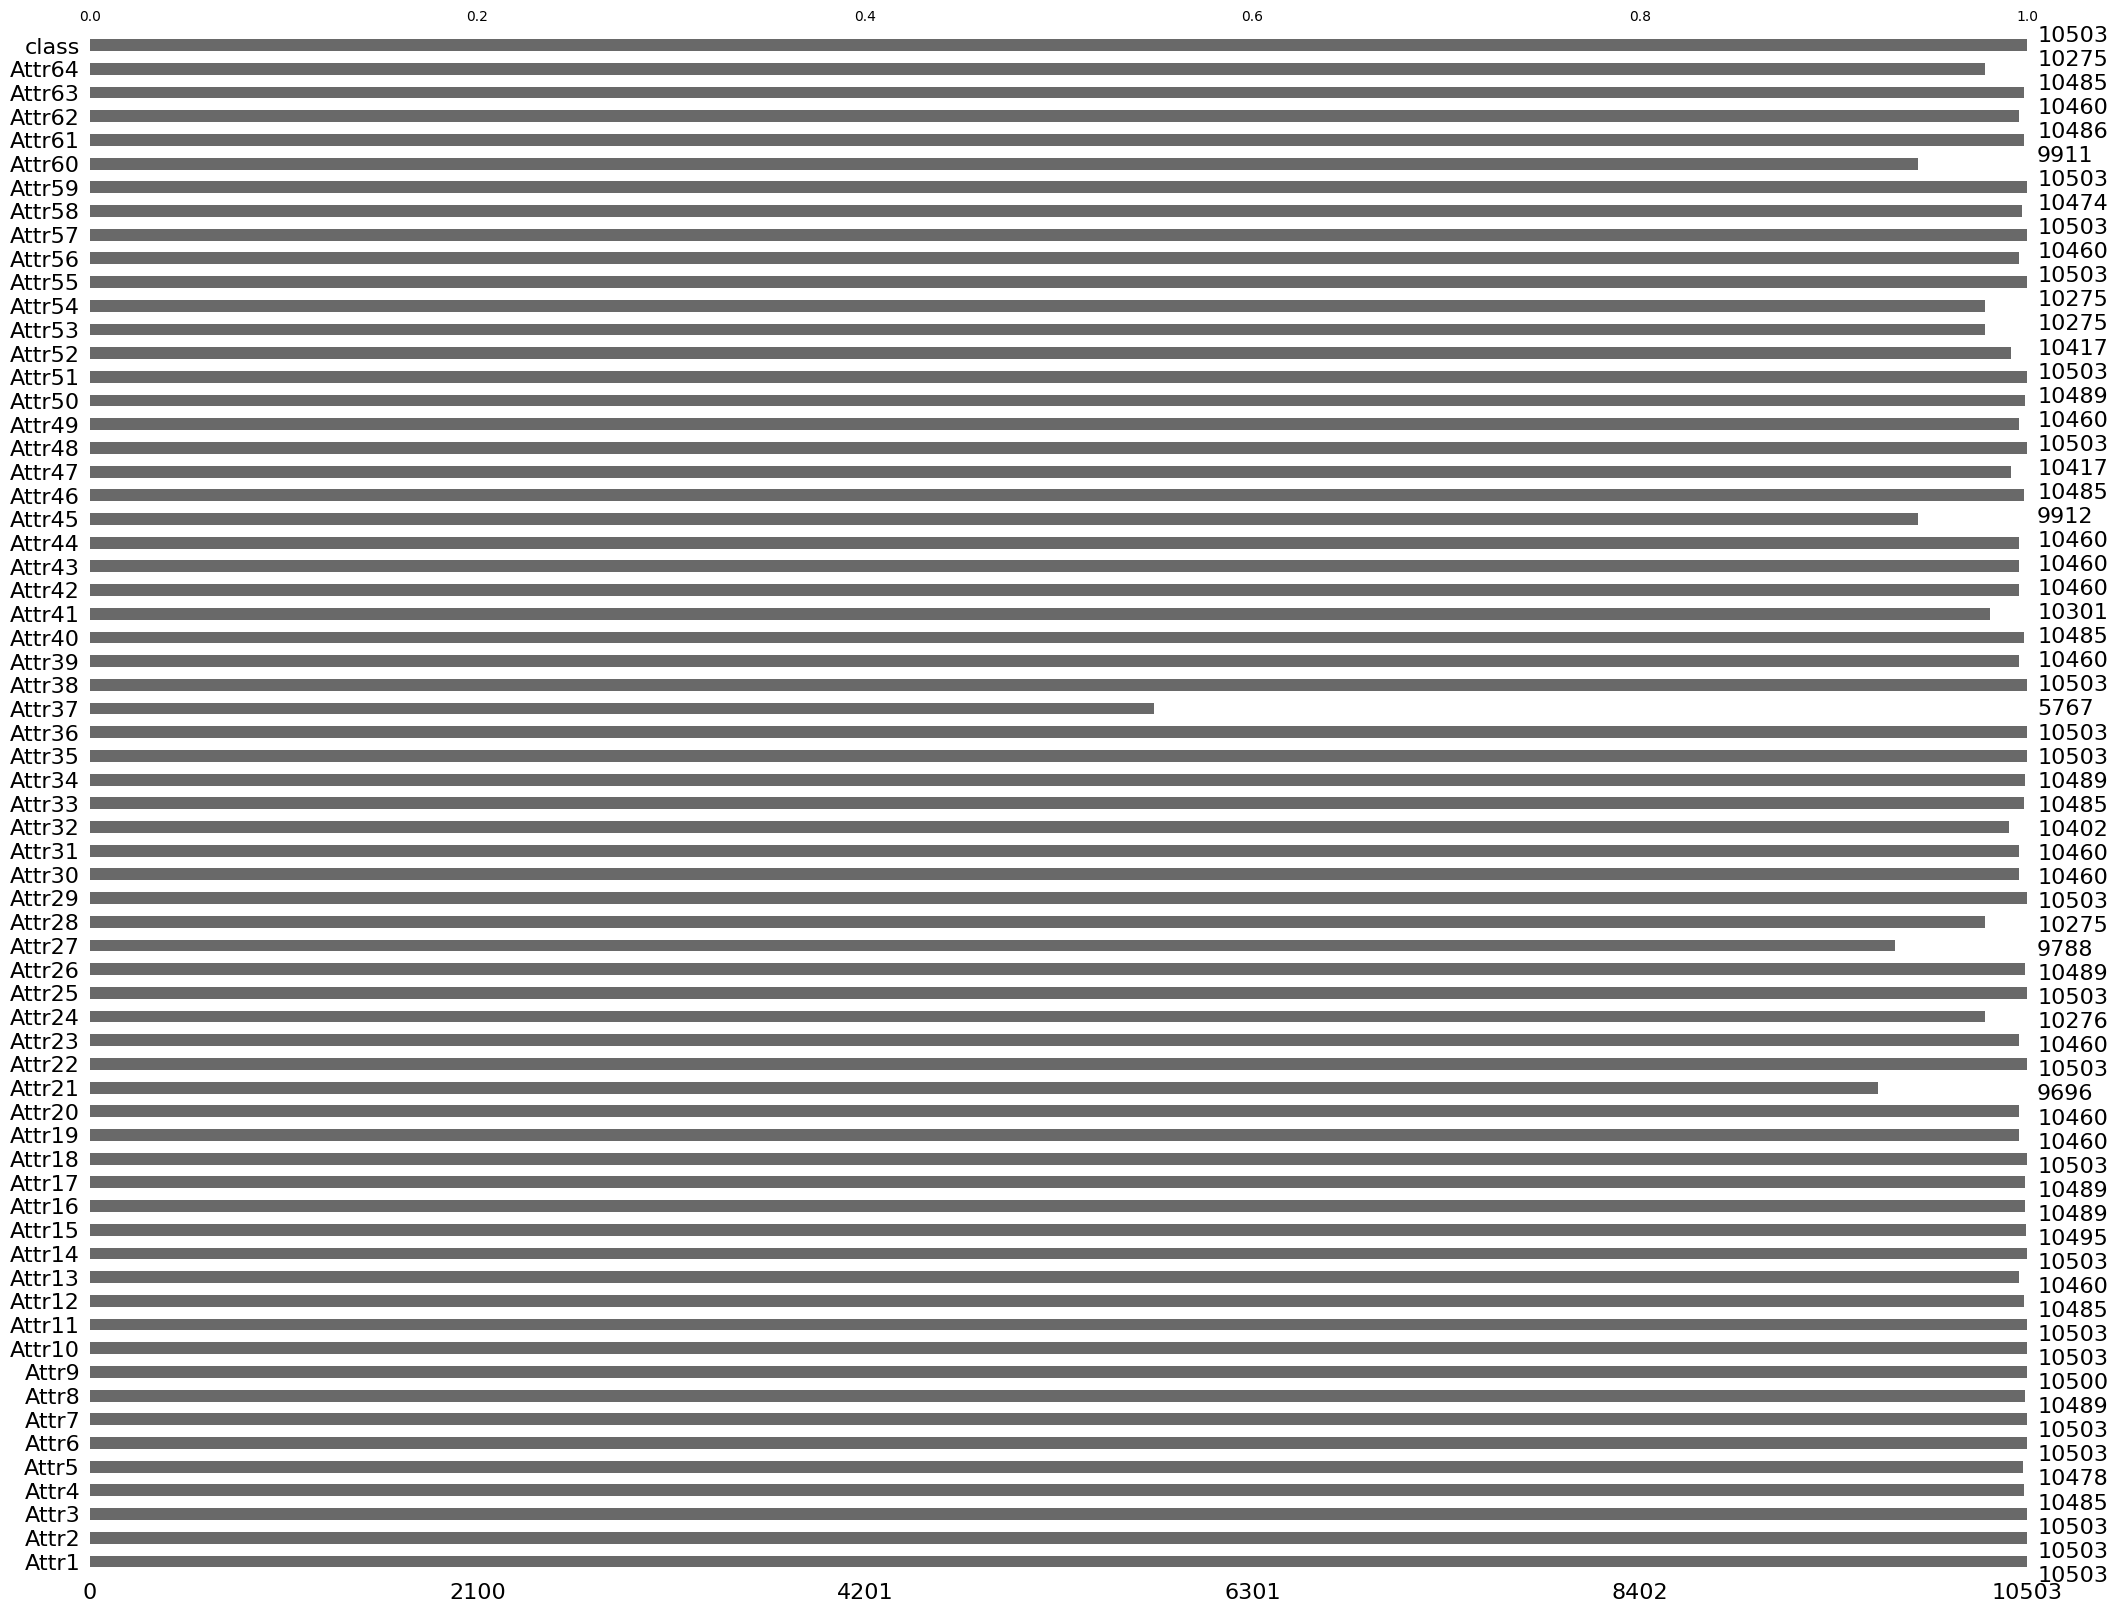

In [6]:

plt.figure()
msno.matrix(df)
plt.figure()
msno.bar(df)

In [7]:
print(f"Percentage of missing values: {df.isnull().sum().sort_values().sum()/(df.shape[0] * (df.shape[1] - 1))* 100:.2f}%")

Percentage of missing values: 1.47%


## 4. Outlier Removal

In [8]:
df_no_obj_val = df[non_object_values]
# # z score filtering is shit as mean and std are heavily skewed
# z_score_abs = np.abs((df_no_obj_val - df_no_obj_val.mean())/df_no_obj_val.std(ddof=0))
# z_score_abs.to_csv('z_score')
# df_new = df_no_obj_val[~((z_score_abs > 3).any(axis=1))]
# display(df_new)
# display(df_new.describe().T)


# quantile filtering -> remove 1% of biggest and 1% os smallest values
Q1 = df_no_obj_val.quantile(0.01) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = df_no_obj_val.quantile(0.99)
IQR = Q3 - Q1
condition = ~((df_no_obj_val < (Q1 - 1.5 * IQR)) | (df_no_obj_val > (Q3 + 1.5 * IQR))).any(axis=1)
df_new = df[condition]


display(df_new)
display(df_new.describe().T)

if not perform_outlier_removal:
    df_new = df

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
1,0.146240,0.46038,0.282300,1.62940,2.5952,0.000000,0.171850,1.172100,1.60180,0.539620,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,Not bankrupt
2,0.000595,0.22612,0.488390,3.15990,84.8740,0.191140,0.004572,2.988100,1.00770,0.675660,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,Not bankrupt
3,0.024526,0.43236,0.275460,1.78330,-10.1050,0.569440,0.024526,1.305700,1.05090,0.564530,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,Not bankrupt
4,0.188290,0.41504,0.342310,1.92790,-58.2740,0.000000,0.233580,1.409400,1.33930,0.584960,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,Not bankrupt
5,0.182060,0.55615,0.321910,1.60450,16.3140,0.000000,0.182060,0.798080,1.81260,0.443850,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,Not bankrupt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10498,0.002861,0.58067,-0.223860,0.51658,-31.8660,0.002861,0.002861,0.618550,1.01200,0.359170,...,0.011834,0.007966,0.98817,0.327360,38.1420,39.1500,42.202,8.6489,5.2646,Bankrupt
10499,-0.051968,0.55254,0.147150,2.16980,12.7480,-0.051968,-0.034361,0.669830,0.94694,0.370110,...,-0.056037,-0.140410,1.05600,1.153000,14.4930,9.2851,32.761,11.1410,1.9276,Bankrupt
10500,-0.135900,0.83954,-0.342010,0.46526,-145.3100,-0.219120,-0.131860,0.191130,1.09990,0.160460,...,0.144120,-0.846930,0.85427,0.814200,6.2737,9.6966,212.230,1.7198,1.5659,Bankrupt
10501,0.009423,0.50028,0.261630,1.52300,-10.1580,0.009423,0.007700,0.989900,1.01230,0.495230,...,0.012186,0.019027,0.98781,0.000000,5.9675,4.3536,98.240,3.7154,7.8068,Bankrupt


,count,mean,std,min,25%,50%,75%,max
Attr1,9656.0,0.052758,0.187549,-1.904700,0.002431,0.044999,0.123305,1.8017
Attr2,9656.0,0.502684,0.350117,0.000000,0.259310,0.461710,0.675988,4.4681
Attr3,9656.0,0.197824,0.341853,-3.494800,0.022891,0.200265,0.411287,1.0000
Attr4,9649.0,2.805910,4.136348,0.031843,1.055100,1.606600,2.872200,77.2500
Attr5,9635.0,3.040430,762.693453,-11723.000000,-49.825500,1.360200,52.787500,13017.0000
...,...,...,...,...,...,...,...,...
Attr60,9224.0,30.694768,109.967059,0.000000,5.561825,9.904350,20.263250,2256.8000
Attr61,9649.0,10.476545,15.326498,0.000000,4.556000,6.709000,10.499000,249.4700
Attr62,9646.0,99.854477,122.587212,0.000000,41.586750,70.597000,115.695000,2418.7000
Attr63,9649.0,7.585579,8.710742,0.000000,3.148500,5.162400,8.765500,135.3500


## 5. Plots

### 5.1 Distribution of target variable

Text(0.5, 0, 'Percent')

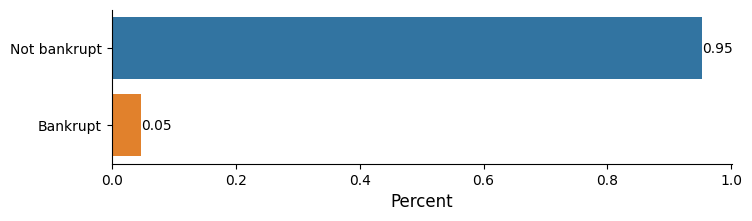

In [9]:
class_counts = df['class'].value_counts()/len(df['class'])
_, ax = plt.subplots(figsize=(8, 2))
sns.despine()
sns.barplot(x=class_counts.values, y=class_counts.index)
ax.bar_label(ax.containers[0], fmt='{:.2f}')
ax.set_xlabel('Percent', fontsize=12)

### 5.2 Correlation Matrix

/tmp/ipykernel_47936/3288021558.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

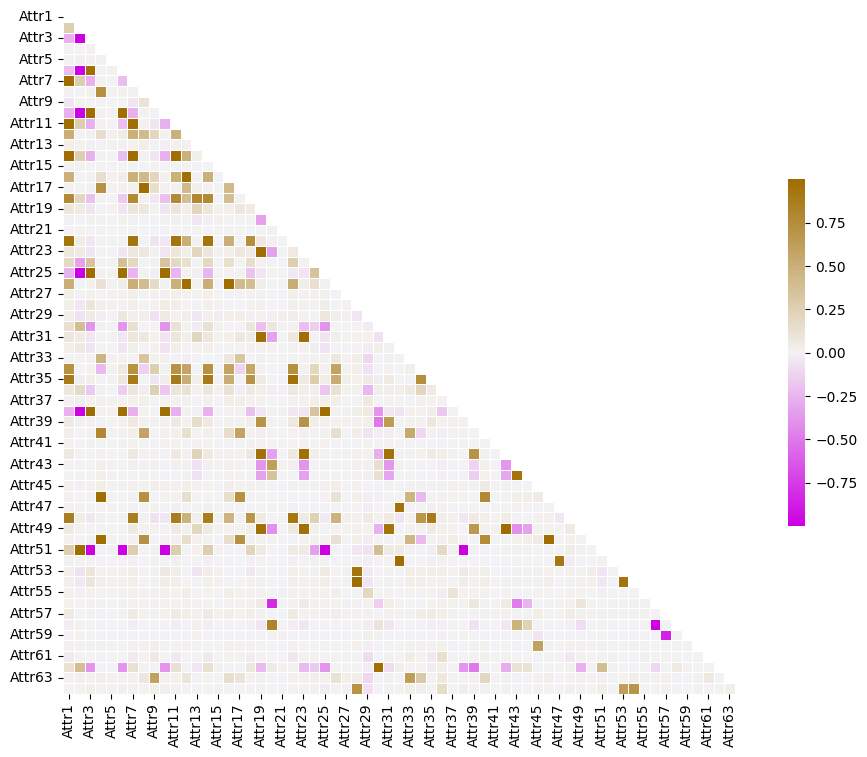

In [10]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(300, 50, s=100, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 5.3 Plots included in report

Text(0.5, 0, 'working capital / total assets')

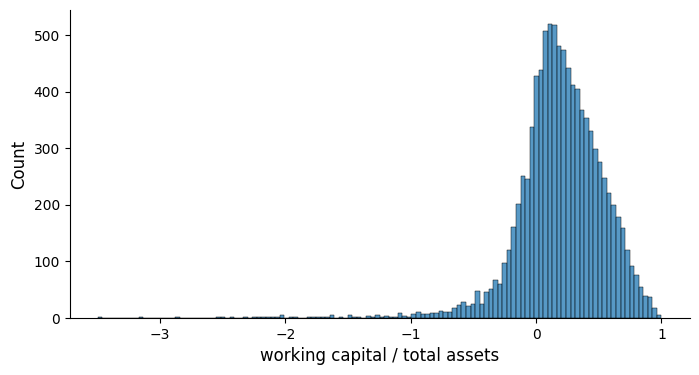

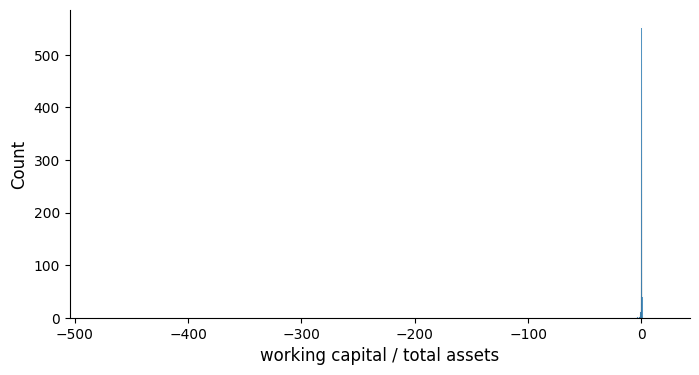

In [11]:
attr_name = 'Attr3'

_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.histplot(data=df_new, x=attr_name)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel(attr_names[attr_name], fontsize=12)

_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.histplot(data=df, x=attr_name)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel(attr_names[attr_name], fontsize=12)

Text(0.5, 0, '(inventory * 365) / sales')

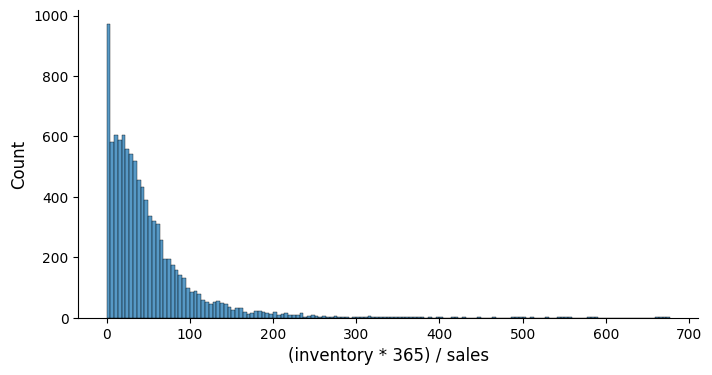

In [12]:
attr_name = 'Attr20'

_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.histplot(data=df_new, x=attr_name)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel(attr_names[attr_name], fontsize=12)

Text(0.5, 0, 'working capital')

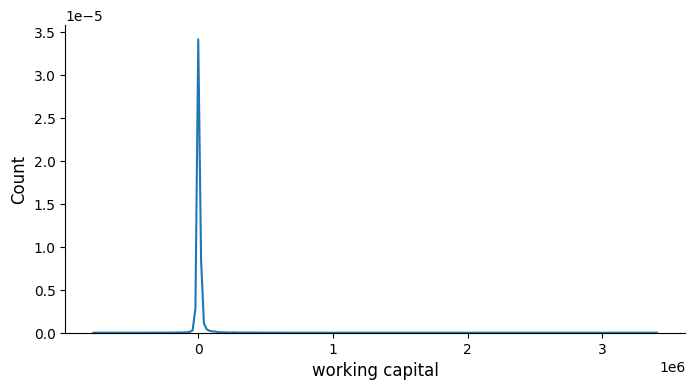

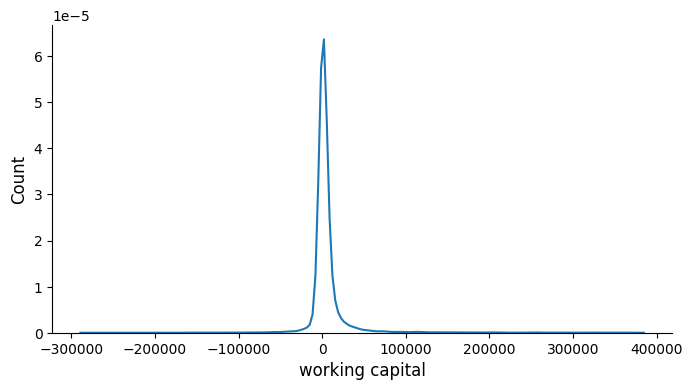

In [25]:
attr_name = 'Attr55'

_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.kdeplot(data=df, x=attr_name)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel(attr_names[attr_name], fontsize=12)

# same attributes with outliers removed
_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.kdeplot(data=df_new, x=attr_name)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel(attr_names[attr_name], fontsize=12)

## 6. Generate Plots for all Attributes
Commented out due to taking long. Was used for exploring attribute ranges and distributions.

In [11]:

plots_save_dir = 'plots/'
if not os.path.exists(plots_save_dir):
    os.makedirs(plots_save_dir)

### 6.1 Scatterplots and KDE-plots

In [12]:
colnames = [col for col in df.columns]
# takes 10 min to run
# for colname_x in colnames:
#     for colname_y in colnames:
#         plt.figure()
#         if colname_x == colname_y and colname_x != 'class':
#             plot = sns.kdeplot(data=df, x=colname_x)
#             fig = plot.get_figure()
#             fig.savefig(f"{plots_save_dir}/kdeplot_{colname_x}")
#         else:
#             plot = sns.scatterplot(data=df, x=colname_x, y=colname_y)
#             fig = plot.get_figure()
#             fig.savefig(f"{plots_save_dir}/scatterplot_{colname_x}_{colname_y}")
#         plt.close()





### 6.2 Only kdeplots

In [13]:
# for colname in colnames:
#         plt.figure()
#         if colname == 'class':
#                 continue
#         plot = sns.kdeplot(data=df_new, x=colname)
#         fig = plot.get_figure()
#         fig.savefig(f"{plots_save_dir}/kdeplot_{colname}")
#         plt.close()

### 6.3 Histograms

In [14]:
# for colname in colnames:
#         plt.figure()
#         if colname == 'class':
#                 continue
#         plot = sns.histplot(data=df_new, x=colname)
#         fig = plot.get_figure()
#         fig.savefig(f"{plots_save_dir}/histplot_{colname}")
#         plt.close()

### 6.4 Violinplots

In [15]:

# for colname in colnames:
#     if colname == 'class':
#         continue
#     plot = sns.violinplot(data=df_new, x=colname)
#     fig = plot.get_figure()
#     fig.savefig(f"{plots_save_dir}/violinplot_{colname}")
#     plt.close()